In [13]:
import altair as alt
from altair.expr import datum, if_
import datetime
import json
import numpy as np
import pandas as pd
import psycopg2
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 25)
pd.options.display.float_format = "{:,.2f}".format

Connect to the database.

In [16]:
with open("config.json") as f:
    conf = json.load(f)
conn = psycopg2.connect(
    dbname=conf["database"],
    user=conf["user"],
    host=conf["host"],
    password=conf["password"]
)
conn.autocommit = True

## Which families gave at least $50,000 between Nov. 2 and Dec. 31, 2017?

In [ ]:
megadonors = pd.read_sql("""CREATE TABLE IF NOT EXISTS megadonors AS
SELECT cycle,
       left(contribid,
            11) AS family_id,
       max(contrib) AS contributor, date, sum(amount), cmteid AS cmte_id
FROM crp_contributions
WHERE date >= '2017-11-02'
  AND date <= '2017-12-31'
  AND amount >= 50000
GROUP BY CYCLE,
         family_id, date, cmte_id
LIMIT 10;
""")

In [2]:
forbes_contributions_18 = pd.read_csv("https://dash.fivetwentyseven.com/api/queries/599/results.csv?api_key=DGS1Mwb6QGEMRUkeusDTyytToptOKx4eCCy8Wpq2",
                                   dtype={"cycle": "category", "state": "category", "recipcode": "category", "realcode": "category",
                                   "type": "category", "gender": "category", "source": "category", "contributor_id": "category"})
forbes_contributions_18["date"] = pd.to_datetime(forbes_contributions_18["date"])
forbes_contributions_18["date"] = pd.DatetimeIndex(forbes_contributions_18["date"]).normalize()
forbes_contributions_18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7504 entries, 0 to 7503
Data columns (total 25 columns):
cycle             7504 non-null category
fectransid        7504 non-null int64
contribid         7504 non-null object
contrib           7504 non-null object
recipid           7504 non-null object
orgname           7032 non-null object
ultorg            735 non-null object
realcode          7504 non-null category
date              7504 non-null datetime64[ns]
amount            7504 non-null int64
street            0 non-null float64
city              7503 non-null object
state             7504 non-null category
zip               7504 non-null object
recipcode         7504 non-null category
type              7504 non-null category
cmteid            7504 non-null object
otherid           837 non-null object
gender            7504 non-null category
microfilm         7504 non-null object
occupation        7217 non-null object
employer          6916 non-null object
source            750

## Import and format CRP contributions data for 2014

In [3]:
forbes_contributions_14 = pd.read_csv("https://dash.fivetwentyseven.com/api/queries/600/results.csv?api_key=FfDdgMSONMliaHYyL85d3E4Ty2XaOa0fda7jjpbk",
                                      dtype={"cycle": "category", "state": "category", "recipcode": "category", "realcode": "category",
                                   "type": "category", "gender": "category", "source": "category", "contributor_id": "category"})
forbes_contributions_14["date"] = pd.to_datetime(forbes_contributions_14["date"])
forbes_contributions_14["date"] = pd.DatetimeIndex(forbes_contributions_14["date"]).normalize()
forbes_contributions_14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8428 entries, 0 to 8427
Data columns (total 25 columns):
cycle             8428 non-null category
fectransid        8428 non-null int64
contribid         8428 non-null object
contrib           8428 non-null object
recipid           8428 non-null object
orgname           8031 non-null object
ultorg            615 non-null object
realcode          8428 non-null category
date              8428 non-null datetime64[ns]
amount            8428 non-null int64
street            0 non-null float64
city              8424 non-null object
state             8428 non-null category
zip               8428 non-null object
recipcode         8428 non-null category
type              8428 non-null category
cmteid            8428 non-null object
otherid           360 non-null object
gender            8428 non-null category
microfilm         8428 non-null object
occupation        7959 non-null object
employer          7593 non-null object
source            842

## Import and format CRP industry categories.

In [8]:
categories = pd.read_csv("data/CRP_Categories.txt", sep="\t",
                        header=None, names=["cat_code", "category", "industry", "sector"],
                         usecols=[0, 1, 3, 4], dtype={"cat_code": "category"},
                         skiprows=9)
categories.head(1)

,cat_code,category,industry,sector
0,A0000,Agriculture,Misc Agriculture,Agribusiness


## 

## Join committees and categories

In [4]:
committees = pd.read_csv("data/cmtes18.txt", sep=",", header=None, names=["cycle", "cmteid", "pacshort", "affiliate",
                                                                     "ultorg", "recipid", "recipcode", "feccandid",
                                                                     "party", "primcode", "source", "sensitive",
                                                                     "foreign", "active"],
                         dtype={"cycle": "category", "recipcode": "category", "party": "category", "primcode": "category",
                                 "source": "category", "sensitive": "category", "foreign": "category",
                                 "active": "category"}, quotechar="|")
committees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18100 entries, 0 to 18099
Data columns (total 14 columns):
cycle        18100 non-null category
cmteid       18100 non-null object
pacshort     17819 non-null object
affiliate    2109 non-null object
ultorg       8895 non-null object
recipid      18100 non-null object
recipcode    12192 non-null category
feccandid    6632 non-null object
party        9217 non-null category
primcode     8883 non-null category
source       8876 non-null category
sensitive    12187 non-null category
foreign      18100 non-null category
active       18100 non-null category
dtypes: category(8), object(6)
memory usage: 1.0+ MB


In [5]:
categories = pd.read_csv("data/CRP_Categories.txt", sep="\t", header=7, dtype={"Catcode": "category", "Catname": "category",
                                                                          "Catorder": "category", "Industry": "category",
                                                                          "Sector": "category", "Sector Long": "category"})
categories.rename(columns={"Catcode": "catcode", "Catname": "catname", "Catorder": "catorder", "Industry": "industry",
                           "Sector": "sector", "Sector Long": "sectorlong"}, inplace=True)
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 6 columns):
catcode       459 non-null category
catname       459 non-null category
catorder      459 non-null category
industry      459 non-null category
sector        459 non-null category
sectorlong    459 non-null category
dtypes: category(6)
memory usage: 44.0 KB


In [6]:
committees = committees.merge(categories, how="left", left_on="primcode", right_on="catcode")
committees["primcode"] = committees["primcode"].astype("category")
committees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18100 entries, 0 to 18099
Data columns (total 20 columns):
cycle         18100 non-null category
cmteid        18100 non-null object
pacshort      17819 non-null object
affiliate     2109 non-null object
ultorg        8895 non-null object
recipid       18100 non-null object
recipcode     12192 non-null category
feccandid     6632 non-null object
party         9217 non-null category
primcode      8883 non-null category
source        8876 non-null category
sensitive     12187 non-null category
foreign       18100 non-null category
active        18100 non-null category
catcode       8849 non-null category
catname       8849 non-null category
catorder      8849 non-null category
industry      8849 non-null category
sector        8849 non-null category
sectorlong    8849 non-null category
dtypes: category(14), object(6)
memory usage: 1.3+ MB


## Join the Forbes 400 contributions during the 2018 election cycle to the committees.

In [7]:
forbes_contributions_18 = forbes_contributions_18.merge(committees, how="left", on="cmteid")
forbes_contributions_18.drop(["cycle_y", "ultorg_y", "recipcode_y", "source_y"], axis=1, inplace=True)
forbes_contributions_18.rename(columns={"cycle_x": "cycle", "recipid_x": "recipid", "ultorg_x": "ultorg", "recipcode_x": "recipcode", "source_x": "source"}, inplace=True)
forbes_contributions_18.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7504 entries, 0 to 7503
Data columns (total 40 columns):
cycle             7504 non-null category
fectransid        7504 non-null int64
contribid         7504 non-null object
contrib           7504 non-null object
recipid           7504 non-null object
orgname           7032 non-null object
ultorg            735 non-null object
realcode          7504 non-null category
date              7504 non-null datetime64[ns]
amount            7504 non-null int64
street            0 non-null float64
city              7503 non-null object
state             7504 non-null category
zip               7504 non-null object
recipcode         7504 non-null category
type              7504 non-null category
cmteid            7504 non-null object
otherid           837 non-null object
gender            7504 non-null category
microfilm         7504 non-null object
occupation        7217 non-null object
employer          6916 non-null object
source            750

## Join the Forbes 400 contributions during the 2014 election cycle to the committees.

In [8]:
forbes_contributions_14 = forbes_contributions_14.merge(committees, how="left", on="cmteid")
forbes_contributions_14.drop(["cycle_y", "ultorg_y", "recipcode_y", "source_y"], axis=1, inplace=True)
forbes_contributions_14.rename(columns={"cycle_x": "cycle", "recipid_x": "recipid", "ultorg_x": "ultorg", "recipcode_x": "recipcode", "source_x": "source"}, inplace=True)
forbes_contributions_14.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8428 entries, 0 to 8427
Data columns (total 40 columns):
cycle             8428 non-null category
fectransid        8428 non-null int64
contribid         8428 non-null object
contrib           8428 non-null object
recipid           8428 non-null object
orgname           8031 non-null object
ultorg            615 non-null object
realcode          8428 non-null category
date              8428 non-null datetime64[ns]
amount            8428 non-null int64
street            0 non-null float64
city              8424 non-null object
state             8428 non-null category
zip               8428 non-null object
recipcode         8428 non-null category
type              8428 non-null category
cmteid            8428 non-null object
otherid           360 non-null object
gender            8428 non-null category
microfilm         8428 non-null object
occupation        7959 non-null object
employer          7593 non-null object
source            842

## Add an ideology category.

In [9]:
forbes_contributions_18["ideology"] = np.where(forbes_contributions_18["catname"].str.contains("democratic", case=False), "Liberal/Democratic",
                                       np.where(forbes_contributions_18["catname"].str.contains("republican", case=False), "Conservative/Republican", "Other"))
forbes_contributions_14["ideology"] = np.where(forbes_contributions_14["catname"].str.contains("democratic", case=False), "Liberal/Democratic",
                                       np.where(forbes_contributions_14["catname"].str.contains("republican", case=False), "Conservative/Republican", "Other"))
forbes_contributions_18["ideology"] = forbes_contributions_18["ideology"].astype("category")
forbes_contributions_14["ideology"] = forbes_contributions_14["ideology"].astype("category")

In [10]:
forbes_contributions_18["pre_post_introduction"] = np.where(forbes_contributions_18["date"] < "2017-11-02", "Pre-Introduction",
                                                            np.where(forbes_contributions_18["date"] == "2017-11-02", "Day of Introduction",
                                                                     np.where((forbes_contributions_18["date"] > "2017-11-02") & (forbes_contributions_18["date"] <= "2017-12-31"), "Post-Introduction",
                                                                     "Other")))
forbes_contributions_18["pre_post_vote"] = np.where(forbes_contributions_18["date"] < "2017-11-16", "Pre-Vote",
                                                     np.where(forbes_contributions_18["date"] == "2017-11-16", "Day of Vote",
                                                              np.where((forbes_contributions_18["date"] > "2017-11-16") & (forbes_contributions_18["date"] <= "2017-12-31"), "Post-Vote",
                                                                       "Other")))
forbes_contributions_14["pre_post_introduction"] = np.where(forbes_contributions_14["date"] < "2013-11-02", "Pre-Introduction",
                                                            np.where(forbes_contributions_14["date"] == "2013-11-02", "Day of Introduction",
                                                                     np.where((forbes_contributions_14["date"] > "2013-11-02") & (forbes_contributions_14["date"] <= "2013-12-31"), "Post-Introduction",
                                                                     "Other")))
forbes_contributions_14["pre_post_vote"] = np.where(forbes_contributions_14["date"] < "2013-11-16", "Pre-Vote",
                                                     np.where(forbes_contributions_14["date"] == "2013-11-16", "Day of Vote",
                                                              np.where((forbes_contributions_14["date"] > "2013-11-16") & (forbes_contributions_14["date"] <= "2013-12-31"), "Post-Vote",
                                                                       "Other")))
forbes_contributions_18["pre_post_introduction"] = forbes_contributions_18["pre_post_introduction"].astype("category")
forbes_contributions_18["pre_post_vote"] = forbes_contributions_18["pre_post_vote"].astype("category")
forbes_contributions_14["pre_post_introduction"] = forbes_contributions_14["pre_post_introduction"].astype("category")
forbes_contributions_14["pre_post_vote"] = forbes_contributions_14["pre_post_vote"].astype("category")

## House leadership introduced their version of the tax bill on Nov. 2. The first vote on the bill was held on Nov. 16. Let's categorize each contribution as before or after a 90-day period surrounding those dates.

In [11]:
forbes_contributions_18["pre_post_introduction"] = np.where(forbes_contributions_18["date"] < "2017-11-02", "Pre-Introduction",
                                                            np.where(forbes_contributions_18["date"] == "2017-11-02", "Day of Introduction",
                                                                     np.where((forbes_contributions_18["date"] > "2017-11-02") & (forbes_contributions_18["date"] <= "2017-12-31"), "Post-Introduction",
                                                                     "Other")))
forbes_contributions_18["pre_post_vote"] = np.where(forbes_contributions_18["date"] < "2017-11-16", "Pre-Vote",
                                                     np.where(forbes_contributions_18["date"] == "2017-11-16", "Day of Vote",
                                                              np.where((forbes_contributions_18["date"] > "2017-11-16") & (forbes_contributions_18["date"] <= "2017-12-31"), "Post-Vote",
                                                                       "Other")))
forbes_contributions_14["pre_post_introduction"] = np.where(forbes_contributions_14["date"] < "2013-11-02", "Pre-Introduction",
                                                            np.where(forbes_contributions_14["date"] == "2013-11-02", "Day of Introduction",
                                                                     np.where((forbes_contributions_14["date"] > "2013-11-02") & (forbes_contributions_14["date"] <= "2013-12-31"), "Post-Introduction",
                                                                     "Other")))
forbes_contributions_14["pre_post_vote"] = np.where(forbes_contributions_14["date"] < "2013-11-16", "Pre-Vote",
                                                     np.where(forbes_contributions_14["date"] == "2013-11-16", "Day of Vote",
                                                              np.where((forbes_contributions_14["date"] > "2013-11-16") & (forbes_contributions_14["date"] <= "2013-12-31"), "Post-Vote",
                                                                       "Other")))
forbes_contributions_18["pre_post_introduction"] = forbes_contributions_18["pre_post_introduction"].astype("category")
forbes_contributions_18["pre_post_vote"] = forbes_contributions_18["pre_post_vote"].astype("category")
forbes_contributions_14["pre_post_introduction"] = forbes_contributions_14["pre_post_introduction"].astype("category")
forbes_contributions_14["pre_post_vote"] = forbes_contributions_14["pre_post_vote"].astype("category")

## When did 2018 cycle contributions come in around the time of the introduction?

In [12]:
grouped_by_category_18 = forbes_contributions_18.groupby(["ideology", "pre_post_introduction"]).agg({"contributor_id": "nunique", "fectransid": "count", "amount": sum}).reset_index()
grouped_by_category_18.rename(columns={"contributor_id": "num_donors", "fectransid": "num_contributions", "amount": "total_amount"}, inplace=True)
grouped_by_category_18["pct_total_amount"] = grouped_by_category_18["total_amount"] / grouped_by_category_18["total_amount"].sum()
grouped_by_category_18[grouped_by_category_18["total_amount"] > 0].sort_values(["ideology", "pre_post_introduction"], ascending=True).reset_index(drop=True)

,ideology,pre_post_introduction,num_donors,num_contributions,total_amount,pct_total_amount
0,Conservative/Republican,Other,129,1066,19457310,0.17
1,Conservative/Republican,Post-Introduction,91,525,7214809,0.06
2,Conservative/Republican,Pre-Introduction,157,2130,35764078,0.31
3,Liberal/Democratic,Day of Introduction,2,5,16200,0.00
4,Liberal/Democratic,Other,95,1289,27463013,0.24
5,Liberal/Democratic,Post-Introduction,68,458,4302773,0.04
6,Liberal/Democratic,Pre-Introduction,123,1587,11514706,0.10
7,Other,Day of Introduction,3,3,55010,0.00
8,Other,Other,75,145,6448404,0.06
9,Other,Post-Introduction,40,79,1219954,0.01


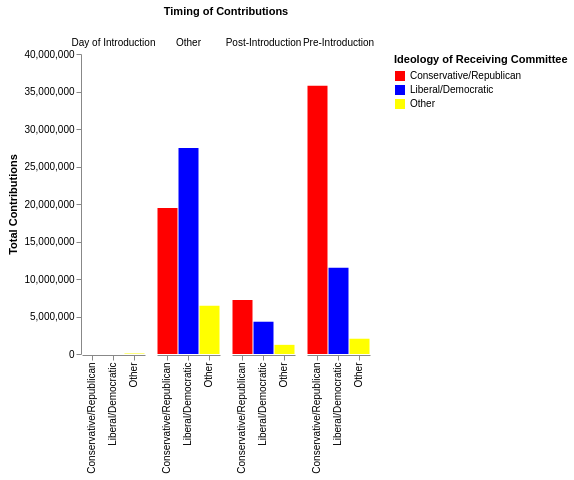

In [13]:
chart = alt.Chart(grouped_by_category_18).mark_bar(size=20).encode(
    alt.X("ideology", axis=alt.Axis(title="", grid=False)),
    alt.Y("total_amount", axis=alt.Axis(title="Total Contributions", grid=False)),
    column = alt.Column("pre_post_introduction", title="Timing of Contributions"),
    color = alt.Color("ideology", scale = alt.Scale(range=["red", "blue", "yellow"]),
                      title="Ideology of Receiving Committee"),
    tooltip = [alt.Tooltip("total_amount", title="Total Contributions")]
).configure_view(
    stroke = "transparent"
)

chart.display()
chart.save("chart_18.html")

## And in 2014?

In [14]:
grouped_by_category_14 = forbes_contributions_14.groupby(["ideology", "pre_post_introduction"]).agg({"contributor_id": "nunique", "fectransid": "count", "amount": sum}).reset_index()
grouped_by_category_14.rename(columns={"contributor_id": "num_donors", "fectransid": "num_contributions", "amount": "total_amount"}, inplace=True)
grouped_by_category_14["pct_total_amount"] = grouped_by_category_14["total_amount"] / grouped_by_category_14["total_amount"].sum()
grouped_by_category_14[grouped_by_category_14["total_amount"] > 0].sort_values(["ideology", "pre_post_introduction"], ascending=True).reset_index(drop=True)

,ideology,pre_post_introduction,num_donors,num_contributions,total_amount,pct_total_amount
0,Conservative/Republican,Other,182,2567,42390910,0.32
1,Conservative/Republican,Post-Introduction,83,336,2039775,0.02
2,Conservative/Republican,Pre-Introduction,152,1069,6985085,0.05
3,Liberal/Democratic,Other,228,2528,50310577,0.38
4,Liberal/Democratic,Post-Introduction,92,301,1984060,0.01
5,Liberal/Democratic,Pre-Introduction,183,1228,14801227,0.11
6,Other,Other,117,239,12371484,0.09
7,Other,Post-Introduction,20,27,125888,0.00
8,Other,Pre-Introduction,89,133,2010210,0.02


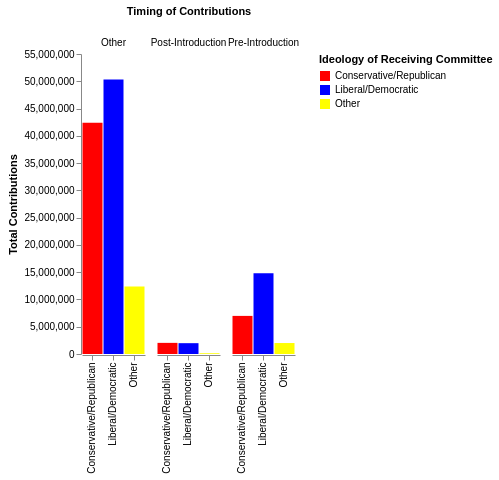

In [15]:
chart = alt.Chart(grouped_by_category_14).mark_bar(size=20).encode(
    alt.X("ideology", axis=alt.Axis(title="", grid=False)),
    alt.Y("total_amount", axis=alt.Axis(title="Total Contributions", grid=False)),
    column = alt.Column("pre_post_introduction", title="Timing of Contributions"),
    color = alt.Color("ideology", scale = alt.Scale(range=["red", "blue", "yellow"]),
                      title="Ideology of Receiving Committee"),
    tooltip = [alt.Tooltip("total_amount", title="Total Contributions")]
).configure_view(
    stroke = "transparent"
)

chart.display()
chart.save("chart_14.html")

## Let's visualize this by donor.

In [16]:
gop_forbes_contributions_18 = forbes_contributions_18[forbes_contributions_18["ideology"] == "Conservative/Republican"]
gop_forbes_contributions_18.to_csv("data/gop_forbes_contributions_18.csv", index=False)

In [17]:
gop_forbes_contributions_14 = forbes_contributions_14[forbes_contributions_14["ideology"] == "Conservative/Republican"]
gop_forbes_contributions_14.to_csv("data/gop_forbes_contributions_14.csv", index=False)

Import the 2018 GOP contributions grouped by donor.

In [18]:
gop_grouped_by_donor_18 = pd.read_csv("https://dash.fivetwentyseven.com/api/queries/608/results.csv?api_key=7wHiLPGSCGzImbe4ZSTU5sYo93TJExjQPNtvc7L5")
gop_grouped_by_donor_18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 4 columns):
contributor_id              179 non-null object
contrib                     179 non-null object
pre_introduction_amount     179 non-null int64
post_introduction_amount    179 non-null int64
dtypes: int64(2), object(2)
memory usage: 5.7+ KB


And the 2014 contributions.

In [19]:
gop_grouped_by_donor_14 = pd.read_csv("https://dash.fivetwentyseven.com/api/queries/609/results.csv?api_key=LD8KmrAafCBpBgtt0kFhZD29UwljcOf4Zr9f6l0p")
gop_grouped_by_donor_14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 4 columns):
contributor_id              205 non-null object
contrib                     205 non-null object
pre_introduction_amount     205 non-null int64
post_introduction_amount    205 non-null int64
dtypes: int64(2), object(2)
memory usage: 6.5+ KB


Join the cycles.

In [20]:
gop_grouped_by_donor = gop_grouped_by_donor_18.merge(gop_grouped_by_donor_14, how="outer", on="contributor_id", suffixes=("_18", "_14"))
gop_grouped_by_donor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229 entries, 0 to 228
Data columns (total 7 columns):
contributor_id                 229 non-null object
contrib_18                     179 non-null object
pre_introduction_amount_18     179 non-null float64
post_introduction_amount_18    179 non-null float64
contrib_14                     205 non-null object
pre_introduction_amount_14     205 non-null float64
post_introduction_amount_14    205 non-null float64
dtypes: float64(4), object(3)
memory usage: 14.3+ KB


In [21]:
gop_grouped_by_donor.head()

,contributor_id,contrib_18,pre_introduction_amount_18,post_introduction_amount_18,contrib_14,pre_introduction_amount_14,post_introduction_amount_14
0,U0000003234,"ROWLING, ROBERT MR","57,700.00","2,700.00","ROWLING, TRAVIS BLAKE MR","75,200.00","42,800.00"
1,i3003607212,"SHOEN, MARK",0.00,0.00,"SHOEN, MARK",750.00,0.00
2,j1001212019,"SOONSHIONG, PATRICK MR","105,000.00",0.00,NaN,nan,nan
3,U0000004022,"THIEL, PETER MR","147,300.00","99,400.00","THIEL, PETER MR","5,000.00","10,400.00"
4,h3001352487,"HILDEBRAND, MELINDA MRS","193,799.00","260,400.00","HILDEBRAND, MELINDA B MRS","28,675.00","37,600.00"


Calculate percent by time period of contribution.

In [22]:
gop_grouped_by_donor["pct_pre_introduction_18"] = gop_grouped_by_donor["pre_introduction_amount_18"] / (gop_grouped_by_donor["pre_introduction_amount_18"] + gop_grouped_by_donor["post_introduction_amount_18"])
gop_grouped_by_donor["pct_post_introduction_18"] = gop_grouped_by_donor["post_introduction_amount_18"] / (gop_grouped_by_donor["pre_introduction_amount_18"] + gop_grouped_by_donor["post_introduction_amount_18"])
gop_grouped_by_donor["pct_pre_introduction_14"] = gop_grouped_by_donor["pre_introduction_amount_14"] / (gop_grouped_by_donor["pre_introduction_amount_14"] + gop_grouped_by_donor["post_introduction_amount_14"])
gop_grouped_by_donor["pct_post_introduction_14"] = gop_grouped_by_donor["post_introduction_amount_14"] / (gop_grouped_by_donor["pre_introduction_amount_14"] + gop_grouped_by_donor["post_introduction_amount_14"])

In [23]:
gop_grouped_by_donor.head(1)

,contributor_id,contrib_18,pre_introduction_amount_18,post_introduction_amount_18,contrib_14,pre_introduction_amount_14,post_introduction_amount_14,pct_pre_introduction_18,pct_post_introduction_18,pct_pre_introduction_14,pct_post_introduction_14
0,U0000003234,"ROWLING, ROBERT MR","57,700.00","2,700.00","ROWLING, TRAVIS BLAKE MR","75,200.00","42,800.00",0.96,0.04,0.64,0.36


How many Republican donors gave more after the tax bill than they had before it in 2017?

In [24]:
gop_grouped_by_donor[(gop_grouped_by_donor["post_introduction_amount_18"] > gop_grouped_by_donor["pre_introduction_amount_18"])].reset_index(drop=True)

,contributor_id,contrib_18,pre_introduction_amount_18,post_introduction_amount_18,contrib_14,pre_introduction_amount_14,post_introduction_amount_14,pct_pre_introduction_18,pct_post_introduction_18,pct_pre_introduction_14,pct_post_introduction_14
0,h3001352487,"HILDEBRAND, MELINDA MRS","193,799.00","260,400.00","HILDEBRAND, MELINDA B MRS","28,675.00","37,600.00",0.43,0.57,0.43,0.57
1,f1000211954,"CLINE, CHRISTOPHER MR",0.00,"5,400.00","CLINE, CHRISTOPHER",0.00,"5,200.00",0.00,1.00,0.00,1.00
2,a0000115053,"LAUDER, RONALD S HON","45,800.00","105,400.00",NaN,nan,nan,0.30,0.70,nan,nan
3,U0000004640,"FISHER, LAURA MRS OTHER","128,400.00","495,200.00","FISHER, LAURA MRS","137,600.00","20,800.00",0.21,0.79,0.87,0.13
4,U0000003085,"RENNERT, IRA LEON",0.00,"40,000.00","RENNERT, IRA LEON MR","30,000.00","64,800.00",0.00,1.00,0.32,0.68
5,U0000000002,"DEVOS, SR, RICHARD MR","8,100.00","25,400.00","DEVOS, RICK","30,350.00","78,800.00",0.24,0.76,0.28,0.72
6,a0000267258,"MORRIS, JOHN L MR",0.00,"2,500.00","MORRIS, JOHN L MR",0.00,0.00,0.00,1.00,nan,nan
7,d1007795455,"PUCKER, MICHAEL MR",-400.00,0.00,NaN,nan,nan,1.00,-0.00,nan,nan
8,a0000672626,"BOYLE, TIMOTHY P",0.00,500.00,"BOYLE, TIMOTHY P MR","80,200.00",0.00,0.00,1.00,1.00,0.00
9,e1110617847,"ALLEN, PAUL MR OTHER","30,500.00","39,000.00","ALLEN, PAUL G","15,000.00","5,000.00",0.44,0.56,0.75,0.25


And in 2013?

In [25]:
gop_grouped_by_donor[(gop_grouped_by_donor["post_introduction_amount_14"] > gop_grouped_by_donor["pre_introduction_amount_14"])].reset_index(drop=True)

,contributor_id,contrib_18,pre_introduction_amount_18,post_introduction_amount_18,contrib_14,pre_introduction_amount_14,post_introduction_amount_14,pct_pre_introduction_18,pct_post_introduction_18,pct_pre_introduction_14,pct_post_introduction_14
0,U0000004022,"THIEL, PETER MR","147,300.00","99,400.00","THIEL, PETER MR","5,000.00","10,400.00",0.60,0.40,0.32,0.68
1,h3001352487,"HILDEBRAND, MELINDA MRS","193,799.00","260,400.00","HILDEBRAND, MELINDA B MRS","28,675.00","37,600.00",0.43,0.57,0.43,0.57
2,f1000211954,"CLINE, CHRISTOPHER MR",0.00,"5,400.00","CLINE, CHRISTOPHER",0.00,"5,200.00",0.00,1.00,0.00,1.00
3,c0060071181,"FRIEDKIN, THOMAS","15,000.00",0.00,"FRIEDKIN, TOM D MR",0.00,"2,600.00",1.00,0.00,0.00,1.00
4,j1001127091,"DAVIS, RAYMOND C MR","10,400.00",0.00,"DAVIS, RAY",0.00,"5,000.00",1.00,0.00,0.00,1.00
5,h3001931831,"MORENO, CAROLE MRS","21,600.00",0.00,"MORENO, CAROLE D MRS",0.00,"2,600.00",1.00,0.00,0.00,1.00
6,h1001169958,"BARNETT, HOYT R MR","30,400.00","10,800.00","BARNETT, HOYT R MR",0.00,"92,600.00",0.74,0.26,0.00,1.00
7,U0000003085,"RENNERT, IRA LEON",0.00,"40,000.00","RENNERT, IRA LEON MR","30,000.00","64,800.00",0.00,1.00,0.32,0.68
8,U0000000002,"DEVOS, SR, RICHARD MR","8,100.00","25,400.00","DEVOS, RICK","30,350.00","78,800.00",0.24,0.76,0.28,0.72
9,U0000000267,"BLACK, LEON MR","46,100.00","1,000.00","BLACK, LEON MR","25,000.00","37,400.00",0.98,0.02,0.40,0.60


How many Republican donors gave more, proportionally, after the tax bill than they had given, proportionally, after the same date four years earlier?

In [26]:
gave_more = gop_grouped_by_donor[(gop_grouped_by_donor["pct_post_introduction_18"] > gop_grouped_by_donor["pct_post_introduction_14"])].reset_index(drop=True)

And how many did not?

In [27]:
gop_grouped_by_donor[(gop_grouped_by_donor["pct_post_introduction_18"] < gop_grouped_by_donor["pct_post_introduction_14"])].reset_index(drop=True)

,contributor_id,contrib_18,pre_introduction_amount_18,post_introduction_amount_18,contrib_14,pre_introduction_amount_14,post_introduction_amount_14,pct_pre_introduction_18,pct_post_introduction_18,pct_pre_introduction_14,pct_post_introduction_14
0,U0000003234,"ROWLING, ROBERT MR","57,700.00","2,700.00","ROWLING, TRAVIS BLAKE MR","75,200.00","42,800.00",0.96,0.04,0.64,0.36
1,U0000004022,"THIEL, PETER MR","147,300.00","99,400.00","THIEL, PETER MR","5,000.00","10,400.00",0.60,0.40,0.32,0.68
2,U0000003619,"PEROT, SARAH F","480,700.00","13,500.00","PEROT, SARAH F MRS","22,300.00","17,550.00",0.97,0.03,0.56,0.44
3,c0060071181,"FRIEDKIN, THOMAS","15,000.00",0.00,"FRIEDKIN, TOM D MR",0.00,"2,600.00",1.00,0.00,0.00,1.00
4,j1001127091,"DAVIS, RAYMOND C MR","10,400.00",0.00,"DAVIS, RAY",0.00,"5,000.00",1.00,0.00,0.00,1.00
5,a0000345908,"SCHUSTERMAN, LYNN MS","10,800.00",0.00,"SCHUSTERMAN, LYNN MS","5,200.00","2,600.00",1.00,0.00,0.67,0.33
6,U0000003830,"LOEB, MARGIE","503,100.00","12,700.00","LOEB, MARJORIE MRS","37,600.00","2,000.00",0.98,0.02,0.95,0.05
7,U0000003551,"SMITH, FREDERICK W MR","5,400.00",0.00,"SMITH, FRED MR","134,600.00","2,600.00",1.00,0.00,0.98,0.02
8,U0000003523,"HUNT, WOODY L MR","590,334.00","8,900.00","HUNT, WOODY MR","119,900.00","12,500.00",0.99,0.01,0.91,0.09
9,U0000004655,"REYES, J MR","943,600.00","25,000.00","REYES, J CHRISTOPHER MR","115,600.00","5,200.00",0.97,0.03,0.96,0.04


## To which committees did the 44 donors whose giving patterns changed between cycles give in 2013 and in 2017?

In [92]:
gave_more_recipients_18 = forbes_contributions_18.merge(gave_more, on="contributor_id")
gave_more_recipients_18 = gave_more_recipients_18[(gave_more_recipients_18["ideology"] == "Conservative/Republican") & (gave_more_recipients_18["pre_post_introduction"] != "Other")]
gave_more_recipients_18 = gave_more_recipients_18[["cmteid", "pacshort", "affiliate", "catname", "amount", "date", "pre_post_introduction", "contributor_id", "contrib_18", "cycle"]]
gave_more_recipients_18.head(1)

,cmteid,pacshort,affiliate,catname,amount,date,pre_post_introduction,contributor_id,contrib_18,cycle
0,C00570994,Alaskans for Dan Sullivan,NaN,Republican Candidate Committees,2700,2016-06-09,Pre-Introduction,h3001352487,"HILDEBRAND, MELINDA MRS",2018


In [93]:
gave_more_recipients_14 = forbes_contributions_14.merge(gave_more, on="contributor_id")
gave_more_recipients_14 = gave_more_recipients_14[(gave_more_recipients_14["ideology"] == "Conservative/Republican") & (gave_more_recipients_14["pre_post_introduction"] != "Other")]
gave_more_recipients_14 = gave_more_recipients_14[["cmteid", "pacshort", "affiliate", "catname", "amount", "date", "pre_post_introduction", "contributor_id", "contrib_14", "cycle"]]
gave_more_recipients_14.head(1)

,cmteid,pacshort,affiliate,catname,amount,date,pre_post_introduction,contributor_id,contrib_14,cycle
0,C00003418,Republican National Cmte,Republican National Cmte,Republican Party Committees,5000,2012-09-07,Pre-Introduction,U0000003477,"KOCH, ELIZABETH MS",2014


And how does that look grouped by committee?

In [94]:
gave_more_recipients_18 = gave_more_recipients_18.groupby(["pacshort", "pre_post_introduction"]).agg({"amount": sum})
gave_more_recipients_18 = gave_more_recipients_18.pivot_table(values="amount", index="pacshort", columns=["pre_post_introduction"])
gave_more_recipients_18.columns = ["post_introduction_18", "pre_introduction_18"]
gave_more_recipients_18.reset_index(inplace=True)

In [95]:
gave_more_recipients_14 = gave_more_recipients_14.groupby(["pacshort", "pre_post_introduction"]).agg({"amount": sum})
gave_more_recipients_14 = gave_more_recipients_14.pivot_table(values="amount", index="pacshort", columns=["pre_post_introduction"])
gave_more_recipients_14.columns = ["post_introduction_14", "pre_introduction_14"]
gave_more_recipients_14.reset_index(inplace=True)

Join the two cycles.

In [98]:
gave_more_recipients = gave_more_recipients_18.merge(gave_more_recipients_14, how="left", on="pacshort")
gave_more_recipients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232 entries, 0 to 231
Data columns (total 5 columns):
pacshort                232 non-null object
post_introduction_18    115 non-null float64
pre_introduction_18     173 non-null float64
post_introduction_14    20 non-null float64
pre_introduction_14     64 non-null float64
dtypes: float64(4), object(1)
memory usage: 10.9+ KB


## And which of those committees saw the greatest increase in contributions before and after Nov. 2, 2017 and before and after Nov. 2, 2013?

In [103]:
gave_more_recipients.fillna(0, inplace=True)
gave_more_recipients["pct_pre_introduction_18"] = gave_more_recipients["pre_introduction_18"] / (gave_more_recipients["pre_introduction_18"] + gave_more_recipients["post_introduction_18"])
gave_more_recipients["pct_post_introduction_18"] = gave_more_recipients["post_introduction_18"] / (gave_more_recipients["pre_introduction_18"] + gave_more_recipients["post_introduction_18"])
gave_more_recipients["pct_pre_introduction_14"] = gave_more_recipients["pre_introduction_14"] / (gave_more_recipients["pre_introduction_14"] + gave_more_recipients["post_introduction_14"])
gave_more_recipients["pct_post_introduction_14"] = gave_more_recipients["post_introduction_14"] / (gave_more_recipients["pre_introduction_14"] + gave_more_recipients["post_introduction_14"])

In [104]:
gave_more_recipients.head()

,pacshort,post_introduction_18,pre_introduction_18,post_introduction_14,pre_introduction_14,pct_pre_introduction_18,pct_post_introduction_18,pct_pre_introduction_14,pct_post_introduction_14
0,2018 Republican Challengers Fund,0.00,"5,000.00",0.00,0.00,1.00,0.00,nan,nan
1,Adrian Smith for Congress,0.00,"10,800.00",0.00,0.00,1.00,0.00,nan,nan
2,Alamo PAC,"6,500.00","15,000.00",0.00,"15,000.00",0.70,0.30,1.00,0.00
3,Alaskans for Dan Sullivan,"2,000.00","5,400.00",0.00,0.00,0.73,0.27,nan,nan
4,Alaskans for Don Young,"10,800.00",0.00,0.00,0.00,0.00,1.00,nan,nan


In [114]:
gave_more_recipients["post_introduction_change"] = gave_more_recipients["post_introduction_18"] - gave_more_recipients["post_introduction_14"]
gave_more_recipients["post_introduction_pct_change"] = (gave_more_recipients["post_introduction_18"] - gave_more_recipients["post_introduction_14"]) / gave_more_recipients["post_introduction_14"]
gave_more_recipients = gave_more_recipients[["pacshort", "post_introduction_change", "post_introduction_pct_change", "pacshort", "post_introduction_18", "pre_introduction_18", "post_introduction_14", "pre_introduction_14", "pct_pre_introduction_18", "pct_post_introduction_18", "pct_pre_introduction_14", "pct_post_introduction_14"]]

In [120]:
gave_more_recipients[gave_more_recipients["post_introduction_change"] > 0].sort_values("post_introduction_pct_change", ascending=False)

,pacshort,post_introduction_change,post_introduction_pct_change,pacshort,post_introduction_18,pre_introduction_18,post_introduction_14,pre_introduction_14,pct_pre_introduction_18,pct_post_introduction_18,pct_pre_introduction_14,pct_post_introduction_14
2,Alamo PAC,"6,500.00",inf,Alamo PAC,"6,500.00","15,000.00",0.00,"15,000.00",0.70,0.30,1.00,0.00
144,Mortensen for Congress,"26,600.00",inf,Mortensen for Congress,"26,600.00",0.00,0.00,0.00,0.00,1.00,nan,nan
172,Republican Party of North Dakota,"10,000.00",inf,Republican Party of North Dakota,"10,000.00",0.00,0.00,0.00,0.00,1.00,nan,nan
170,Republican Party of Michigan,"20,000.00",inf,Republican Party of Michigan,"20,000.00",0.00,0.00,0.00,0.00,1.00,nan,nan
166,Republican Party of California,"1,000.00",inf,Republican Party of California,"1,000.00",0.00,0.00,0.00,0.00,1.00,nan,nan
161,R Senate PAC,"5,000.00",inf,R Senate PAC,"5,000.00",0.00,0.00,0.00,0.00,1.00,nan,nan
160,Prosperity Action,"11,475.00",inf,Prosperity Action,"11,475.00","80,000.00",0.00,"5,000.00",0.87,0.13,1.00,0.00
158,Portman for Senate,"4,700.00",inf,Portman for Senate,"4,700.00",0.00,0.00,"6,200.00",0.00,1.00,1.00,0.00
156,Pete Stauber for Congress,"10,800.00",inf,Pete Stauber for Congress,"10,800.00",0.00,0.00,0.00,0.00,1.00,nan,nan
155,Perdue for Senate,"16,000.00",inf,Perdue for Senate,"16,000.00",0.00,0.00,0.00,0.00,1.00,nan,nan
